In [3]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pprint
from PIL import Image
import cv2

#### Loading images and annotations from path

In [4]:
CULane_path = '/work/dataset/CULane/'
list_dir = os.listdir(CULane_path)
list_dir = sorted(list_dir)
list_dir = list_dir[:6] # excludes non-relevant dir from whole dir list
list_dir

['driver_100_30frame',
 'driver_161_90frame',
 'driver_182_30frame',
 'driver_193_90frame',
 'driver_23_30frame',
 'driver_37_30frame']

In [5]:
video_list = {}
for dir_name in list_dir:
    video_path = os.path.join(CULane_path, dir_name)
    video_list[video_path] = sorted(os.listdir(video_path))

In [6]:
video_nums = []
for video_name in video_list.keys():
    video_nums.append(len(video_list[video_name]))

video_nums # counts: 110, 310, 141, 341, 354, 20
sum(video_nums)

1178

In [7]:
video_list['/work/dataset/CULane/driver_100_30frame']

['05250325_0272.MP4',
 '05250340_0277.MP4',
 '05250343_0278.MP4',
 '05250358_0283.MP4',
 '05250401_0284.MP4',
 '05250416_0289.MP4',
 '05250419_0290.MP4',
 '05250434_0295.MP4',
 '05250437_0296.MP4',
 '05250452_0301.MP4',
 '05250455_0302.MP4',
 '05250510_0307.MP4',
 '05250523_0308.MP4',
 '05250538_0313.MP4',
 '05250541_0314.MP4',
 '05250556_0319.MP4',
 '05250559_0320.MP4',
 '05250614_0325.MP4',
 '05250617_0326.MP4',
 '05250632_0331.MP4',
 '05250635_0332.MP4',
 '05250650_0337.MP4',
 '05250653_0338.MP4',
 '05250708_0343.MP4',
 '05250711_0344.MP4',
 '05251055_0356.MP4',
 '05251110_0361.MP4',
 '05251113_0362.MP4',
 '05251128_0367.MP4',
 '05251131_0368.MP4',
 '05251146_0373.MP4',
 '05251204_0379.MP4',
 '05251207_0380.MP4',
 '05251222_0385.MP4',
 '05251225_0386.MP4',
 '05251251_0391.MP4',
 '05251254_0392.MP4',
 '05251309_0397.MP4',
 '05251312_0398.MP4',
 '05251327_0403.MP4',
 '05251330_0404.MP4',
 '05251356_0409.MP4',
 '05251408_0410.MP4',
 '05251423_0415.MP4',
 '05251426_0416.MP4',
 '05251441

In [6]:
delete_target = []

image_list = []
anno_list = []
for video_path in video_list.keys():
    images = []
    annos = []
    for videos in video_list[video_path]:
        full_path = os.path.join(video_path, videos)
        image_path = sorted(glob.glob(full_path+'/*.jpg'))
        anno_path = sorted(glob.glob(full_path+'/*.txt'))
        
        if len(image_path)==0:
            print("empty path list: ", full_path)
            delete_target.append(full_path) # if source image is not available, it can't be used at all.
            
        # if annotation is not available, it can't be used for supervised learning. but also it can be used in segmentation label so be careful for deleting this!
        # as annotation .txt file and source image file .jpg are share same directory we need to be very careful for deleting this kinds of situlation
        if len(anno_path)==0:
            print("empty anno list: ", full_path)
            
        if len(image_path) != 0 and len(anno_path) != 0: # neither image_path and anno_path should be empty
            if len(image_path) == len(anno_path):
                images.append(image_path)
                annos.append(anno_path)
            else:
                print("different length between annotation and images :", full_path) # although number of camera source image and annotations are different, the directory must not be deleted.
    
    if len(images) != 0 and len(annos) != 0:  # only append images, annos from each videos if its contents are not empty
        image_list.append(images)
        anno_list.append(annos)

print("number of deletes: ", len(delete_target))
for target in delete_target:
    print("deleting ... ", target)
    os.system(f'rm -rf {target}')

empty path list:  /work/dataset/CULane/laneseg_label_w16/driver_161_90frame
empty anno list:  /work/dataset/CULane/laneseg_label_w16/driver_161_90frame
empty path list:  /work/dataset/CULane/laneseg_label_w16/driver_182_30frame
empty anno list:  /work/dataset/CULane/laneseg_label_w16/driver_182_30frame
empty path list:  /work/dataset/CULane/laneseg_label_w16/driver_23_30frame
empty anno list:  /work/dataset/CULane/laneseg_label_w16/driver_23_30frame
number of deletes:  3
deleting ...  /work/dataset/CULane/laneseg_label_w16/driver_161_90frame
deleting ...  /work/dataset/CULane/laneseg_label_w16/driver_182_30frame
deleting ...  /work/dataset/CULane/laneseg_label_w16/driver_23_30frame


In [7]:
image_list[0][0][0] # {video_folder}/{video_name}/{image_name=.jpg}
anno_list[0][0][0] # {video_folder}/{video_name}/{anno_name=.txt}

'/work/dataset/CULane/driver_100_30frame/05250325_0272.MP4/00000.lines.txt'

In [8]:
# check how image and annotation are different
delete_target = []

imgs = []
labels = []
different_length_list = ['/work/dataset/CULane/driver_100_30frame/05250340_0277.MP4', '/work/dataset/CULane/driver_100_30frame/05252120_0524.MP4']
for target in different_length_list:
    img_container = glob.glob(target+'/*.jpg')
    label_container = glob.glob(target+'/*.txt')
    
    img_name_container = []
    for img in img_container:
        tokens = img.split('/')
        img_name = [tokens[-3], tokens[-2], tokens[-1].split('.')[0]]
        img_name_container.append('/'.join(img_name))
    
    for label in label_container:
        tokens = label.split('/')
        filename = [tokens[-3], tokens[-2], tokens[-1].split('.')[0]]
        filename_s = '/'.join(filename)
        if filename_s not in img_name_container:
            print("files that only exist in label: ", filename_s)
            delete_target.append(label) # camera source image follow same rule for the rest, but annotations are redundant in this case.
        
    print(f"number of images in the {target} dir : ", len(img_container))
    print(f"number of labels in the {target} dir : ", len(label_container))
    print("================================================================")
print("number of deletes: ", len(delete_target))

for target in delete_target:
    print("deleting ... ", target)
    os.system(f'rm -rf {target}')

number of images in the /work/dataset/CULane/driver_100_30frame/05250340_0277.MP4 dir :  20
number of labels in the /work/dataset/CULane/driver_100_30frame/05250340_0277.MP4 dir :  20
number of images in the /work/dataset/CULane/driver_100_30frame/05252120_0524.MP4 dir :  21
number of labels in the /work/dataset/CULane/driver_100_30frame/05252120_0524.MP4 dir :  21
number of deletes:  0


In [9]:
# integrity check
for i in range(len(image_list)):
    
    if image_list[i][0][0].split('/')[-3] != anno_list[i][0][0].split('/')[-3]:
        print("directory ordering between image and annotations are different!")
    
    for j in range(len(image_list[i])):
        
        if image_list[i][j][0].split('/')[-2] != anno_list[i][j][0].split('/')[-2]:
            print("video name ordering between image and annotations are different!")
        
        if len(image_list[i][j]) != len(anno_list[i][j]):
            print("================================================")
            print("number of images and annotations are different!")
            print('/'.join(image_list[i][j][0].split('/')[:-1]))
            print('/'.join(anno_list[i][j][0].split('/')[:-1]))
            print('number of images: ', len(image_list[i][j]))
            print('number of annos: ', len(anno_list[i][j]))
            print("================================================")
            
    if len(image_list[i]) != len(anno_list[i]):
        print("number of videos for annotations and image are different!")
    print()
print("PASS DATA INTEGRITY TEST!")







PASS DATA INTEGRITY TEST!


In [10]:
total_num_images = 0
total_num_annos = 0

distribution = []

for i in range(len(image_list)):
    for j in range(len(image_list[i])):
        total_num_images += len(image_list[i][j])
        total_num_annos += len(anno_list[i][j])
        distribution.append(len(image_list[i][j]))

print("number of train + valid total images: ", total_num_images) # total 133194 images
print("number of train + valid total annos: ", total_num_annos) # total 133194 annotations
print("total number of videos: ", len(distribution)) # total number of video clips are 1176. after preprocessing total 100 video clips are gone.

number of train + valid total images:  133235
number of train + valid total annos:  133235
total number of videos:  1178


In [11]:
# statistic for consecutive frame in each video
distribution = np.array(distribution)
base_str = "number of video clips that contains images equal or less than"
reference = [2, 5, 7, 10, 30, 60, 120, 180]

for num in reference:
    print(base_str +f' {num}: {sum(distribution<(num+1))}')

print('maximum number of images: ', max(distribution))
print('minimum number of images: ', min(distribution))

number of video clips that contains images equal or less than 2: 5
number of video clips that contains images equal or less than 5: 13
number of video clips that contains images equal or less than 7: 17
number of video clips that contains images equal or less than 10: 25
number of video clips that contains images equal or less than 30: 56
number of video clips that contains images equal or less than 60: 612
number of video clips that contains images equal or less than 120: 620
number of video clips that contains images equal or less than 180: 1178
maximum number of images:  180
minimum number of images:  1


#### Visualization

file name:  /work/dataset/CULane/driver_100_30frame/05250419_0290.MP4/01500.jpg
size of images:  (1640, 590)


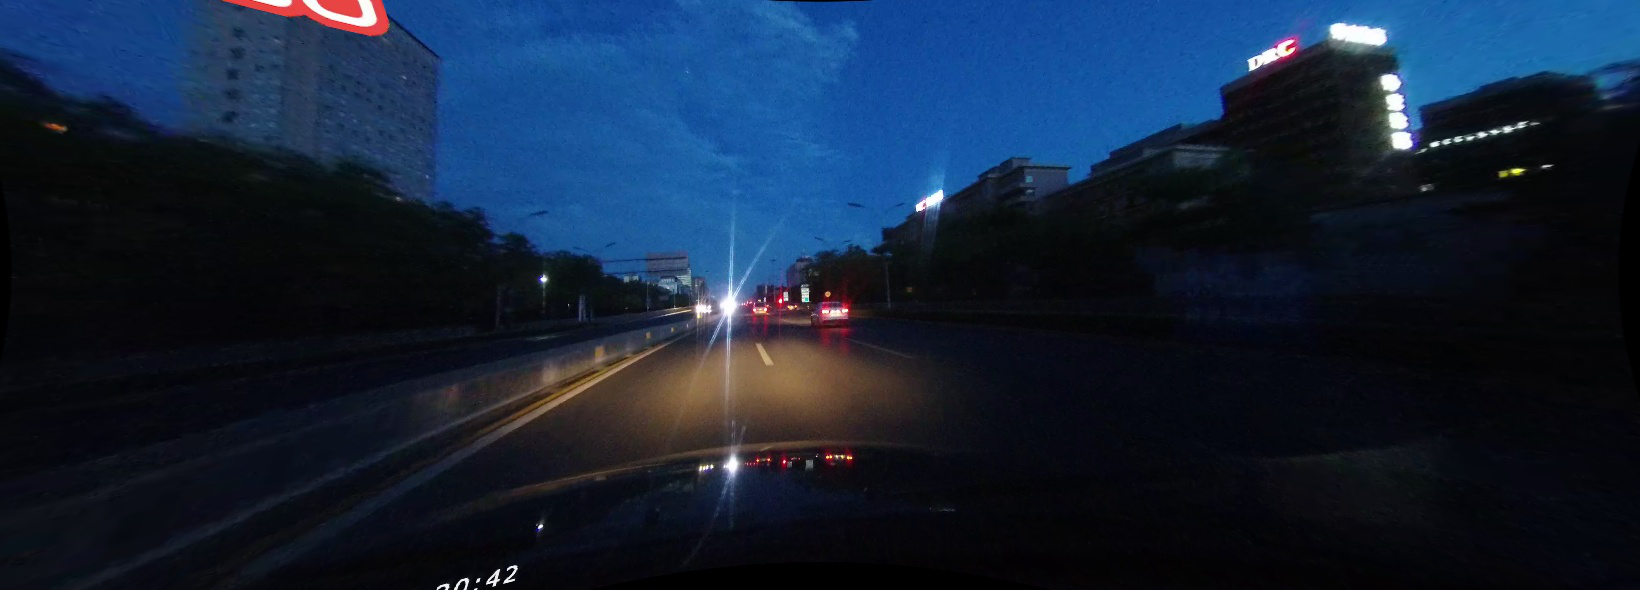

In [12]:
filename = image_list[0][6][50]
ex_img = Image.open(image_list[0][6][50])
print("file name: ", filename)
print("size of images: ", ex_img.size)
ex_img.show()

annotation name:  /work/dataset/CULane/driver_100_30frame/05250419_0290.MP4/01500.lines.txt
number of lanes:  3


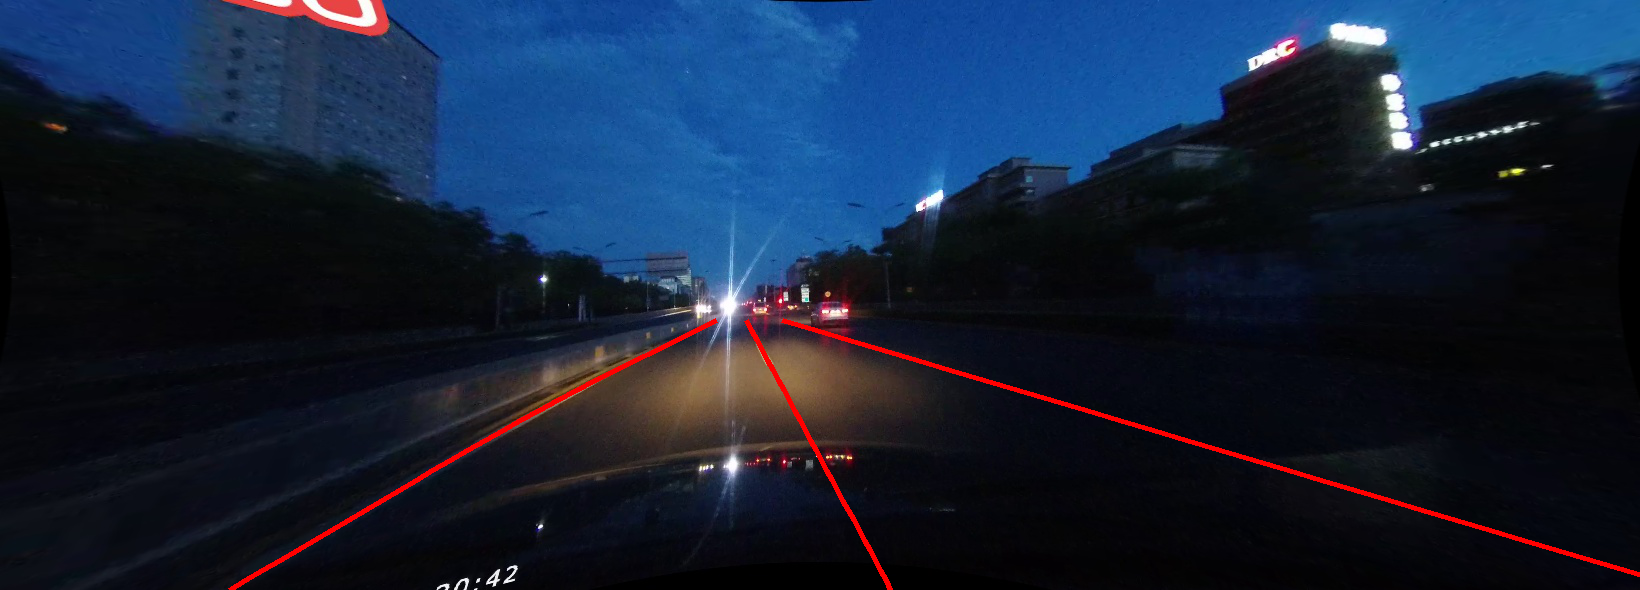

In [13]:
annoname = anno_list[0][6][50]
with open(anno_list[0][6][50], 'r') as fr:
    ex_anno = fr.readlines()
ex_anno = [s.strip() for s in ex_anno]
print("annotation name: ", annoname)
print("number of lanes: ", len(ex_anno))

lines = []
for p_set in ex_anno:
    points = []
    tokens = p_set.split(' ')
    for token in tokens:
        points.append(float(token))
    lines.append(points)

lines_p = []
for line in lines:
    t = []
    for i in range(0, len(line), 2):
        t.append((line[i], line[i+1]))
    lines_p.append(t) # (x, y) coordinate in list sequentially


from PIL import ImageDraw # for drawling line onto image
draw = ImageDraw.Draw(ex_img)

# # draw points on the image
# for line in lines_p:
#     for point_xy in line:
#         draw.point(point_xy)
# ex_img.show()


# draw lines on the image
for line in lines_p:
    for i in range(len(line)-1):
        draw.line((line[i][0], line[i][1], line[i+1][0], line[i+1][1]), fill='red', width=5)
        
ex_img.show()


#### segmentation label

In [14]:
segmentation_anno = CULane_path + 'laneseg_label_w16'
folder_list = sorted(os.listdir(segmentation_anno))
folder_list

[]

In [15]:
video_list = {}
for folder in folder_list:
    videos = sorted(os.listdir(segmentation_anno+f'/{folder}'))
    for video in videos:
        try:
            if video.split('.')[1] != 'MP4':
                videos.remove(video)
                print(video)
        except:
            videos.remove(video)
            print(video)
    video_list[segmentation_anno+f'/{folder}'] = videos
video_list

{}

In [16]:
segmentation_list = []
for path in video_list.keys():
    segmentation_container = []
    for video in video_list[path]:
        segs = sorted(glob.glob(path+f"/{video}/*.png"))
        if len(segs) != 0:
            segmentation_container.append(segs)
    
    if len(segmentation_container) != 0:
        segmentation_list.append(segmentation_container)
segmentation_list # [video_folder][videos][each_image]

[]

In [17]:
num_of_seg = 0
for i in range(len(segmentation_list)):
    for j in range(len(segmentation_list[i])):
        num_of_seg += len(segmentation_list[i][j])

print("number of segmentation annotations: ", num_of_seg) # total 1164 of segmentation annotations

number of segmentation annotations:  0


In [18]:
segmentation_video = {}
for folder in sorted(folder_list):
    videos = sorted(os.listdir(CULane_path + f'/{folder}'))
    for video in videos:
        try:
            if video.split('.')[1] != 'MP4':
                videos.remove(video)
                print(video)
        except:
            videos.remove(video)
            print(video)
    segmentation_video[CULane_path+f'{folder}'] = videos
segmentation_video

{}

In [19]:
for path in video_list.keys():
    print("number of videos in segmentation label folder: ", len(video_list[path])) # videos in segmentation directory

for path in segmentation_video.keys():
    print("number of videos in camera source folder: ", len(segmentation_video[path])) # videos in camera img directory

# the result shows that segmentation folder has 4 more videos than image source folder after deleting empty source folders

In [20]:
delete_target = []

for path in segmentation_video.keys():
    videos = segmentation_video[path]
    
    tokens = path.split('/')
    anno_path = '/'.join([tokens[0], tokens[1], tokens[2], tokens[3], 'laneseg_label_w16', tokens[4]])

    
    for video in videos:
        if video not in video_list[anno_path]:
            if len(glob.glob(path+f'/{video}/*.jpg'))==0:
                print("only video exist in camera img path and have empty contents: ", path+f'/{video}') # as its content is empty, it is useless for both segmentation, point-point labels
                delete_target.append(path+f'/{video}')


for path in video_list.keys():
    videos = video_list[path]
    
    tokens = path.split('/')
    video_path = '/'.join([tokens[0], tokens[1], tokens[2], tokens[3], tokens[5]])

    for video in videos:
        if video not in segmentation_video[video_path]:
            print("only video exist in annotation path!: ", path+f'/{video}') # in this case video only exist in annotation path. it means that it cannot be used at all because of no source image is available.
            delete_target.append(path+f'/{video}')

print("number of empty camera image directory: ", len(delete_target))
for target in delete_target:
    print("deleting ... ", target)
    os.system(f'rm -rf {target}')

number of empty camera image directory:  0


In [21]:
delete_target = []

seg_img_list = []
for path in segmentation_video.keys():
    seg_imgs = []
    for video in segmentation_video[path]:
        imgs = sorted(glob.glob(path+f'/{video}/*.jpg')) # empty video folder is useless.
        if len(imgs)==0:
            print("empty folders: ", path+f'/{video}/*.jpg')
            delete_target.append(path+f'/{video}/*.jpg')
        elif len(imgs) != 0:
            seg_imgs.append(imgs)
    if len(seg_imgs)!= 0:
        seg_img_list.append(seg_imgs)

print("number of deletes: ", len(delete_target))
for target in delete_target:
    print("deleting ... ", target)
    os.system(f'rm -rf {target}')

seg_img_list # [video_folder][video][each image]

number of deletes:  0


[]

In [22]:
len(segmentation_list)
num_of_img_seg = 0

for i in range(len(seg_img_list)):
    for j in range(len(seg_img_list[i])):
        num_of_img_seg += len(seg_img_list[i][j])
print("number of original images corresponding to segmentation_list: ", num_of_img_seg)
# 98555 (number of original camera images) vs 98637 (number of segmentation labels) -> segmentation labels has 82 more images than source images

number of original images corresponding to segmentation_list:  0


In [23]:
import tqdm
seg_img_name_list = []
for i in range(len(seg_img_list)):
    for j in range(len(seg_img_list[i])):
        for k in range(len(seg_img_list[i][j])):
            tokens = seg_img_list[i][j][k].split('/')
            names = [tokens[-3], tokens[-2], tokens[-1].split('.')[0]]
            img_name = '/'.join(names)
            seg_img_name_list.append(img_name)

seg_anno_name_list = []
for i in range(len(segmentation_list)):
    for j in range(len(segmentation_list[i])):
        for k in range(len(segmentation_list[i][j])):
            tokens = segmentation_list[i][j][k].split('/')
            names = [tokens[-3], tokens[-2], tokens[-1].split('.')[0]]
            anno_name = '/'.join(names)
            seg_anno_name_list.append(anno_name)

seg_anno_name_list = sorted(seg_anno_name_list)
seg_img_name_list = sorted(seg_img_name_list)

only_exist_in_original_img = []
for img_name in seg_img_name_list:
    if img_name not in seg_anno_name_list:
        print("only exist in original img path: ", img_name)
        only_exist_in_original_img.append(img_name)

only_exist_in_labels = []
for anno_name in seg_anno_name_list:
    if anno_name not in seg_img_name_list:
        print("only exist in segmentation anno path: ", anno_name)
        only_exist_in_labels.append(anno_name)

print("number of names that only exist in annotation path: ", len(only_exist_in_labels)) # 82 images exist only in annotation path. this is redundancy and need to be deleted...
print("number of names that only exist in original img path: ", len(only_exist_in_original_img)) # 0 images exist only in original source path

number of names that only exist in annotation path:  0
number of names that only exist in original img path:  0


In [24]:
base_path = '/work/dataset/CULane/laneseg_label_w16/'
print("number of deletes: ", len(only_exist_in_labels))

for path in only_exist_in_labels:
    full_path = base_path + path + '.png'
    print("deleting ... ", full_path)
    os.system(f'rm -rf {full_path}')
    

number of deletes:  0


In [25]:
# integrity test
seg_img_list, segmentation_list

for i in range(len(seg_img_list)):
    for j in range(len(seg_img_list[i])):
        for k in range(len(seg_img_list[i][j])):
            tokens = seg_img_list[i][j][k].split('/')
            anno_tokens = segmentation_list[i][j][k].split('/')
            
            img_name = [tokens[-3], tokens[-2], tokens[-1].split('.')[0]]
            anno_name = [anno_tokens[-3], anno_tokens[-2], anno_tokens[-1].split('.')[0]]
            
            img_name_s = '/'.join(img_name)
            anno_name_s = '/'.join(anno_name)
            
            if img_name_s != anno_name_s:
                print("different ordering between original images and annotation label!")
                print("original image: ", img_name_s)
                print("anno image: ", anno_name_s)
                print()

print("PASS DATA INTEGRITY TEST!")

PASS DATA INTEGRITY TEST!


### Now data pre-processing work is done.
number of labels and images for segmentation and point-to-point labels should be same.

### variables
---
segmentation_list : segmentation label path list

seg_img_list : original image corresponding to segmentation label

image_list : original image corresponding to point to point label

anno_list : point to point label list

#### segmentation mask Visualization

In [8]:
ex_seg_img = seg_img_list
print("ex_seg_img: ", ex_seg_img)
ex_img = Image.open(ex_seg_img)
ex_img.show()

NameError: name 'seg_img_list' is not defined

ex_seg_anno:  /work/dataset/CULane/laneseg_label_w16/driver_161_90frame/06030819_0755.MP4/00000.png
annotation shape:  (590, 1640)
annotation value:  [0 1 2 3 4]


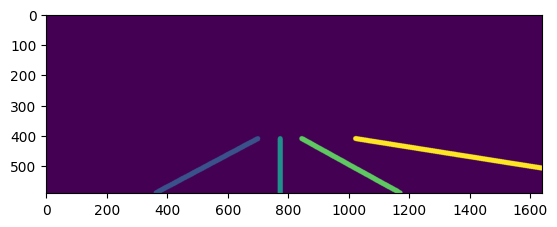

In [53]:
# original mask visualization
ex_seg_label = segmentation_list[0][0][0]
print("ex_seg_anno: ", ex_seg_label)
ex_anno = Image.open(ex_seg_label)
ex_anno = np.asarray(ex_anno)
plt.imshow(ex_anno)

print("annotation shape: ", ex_anno.shape) # 590 x 1640
print("annotation value: ", np.unique(ex_anno)) # 0 -> background, 1 -> first lane, 2 -> second lane, 3 -> third lane, 4 -> fourth lane

In [27]:
new_mask = np.zeros((ex_anno.shape[0], ex_anno.shape[1], 3)) # new mask for visualization
color_list = {'background': (0, 0, 0), '1st_lane' : (255, 0, 0), '2nd_lane' : (0, 255, 0), '3rd_lane' : (0, 0, 255), '4th_lane' : (255, 255, 0)}
num_of_channels = 3

for h in range(ex_anno.shape[0]):
    for w in range(ex_anno.shape[1]):
        if ex_anno[h][w] == 0:
            for i in range(num_of_channels):
                new_mask[h][w][i] = color_list['background'][i]
        if ex_anno[h][w] == 1:
            for i in range(num_of_channels):
                new_mask[h][w][i] = color_list['1st_lane'][i]
        if ex_anno[h][w] == 2:
            for i in range(num_of_channels):
                new_mask[h][w][i] = color_list['2nd_lane'][i]
        if ex_anno[h][w] == 3:
            for i in range(num_of_channels):
                new_mask[h][w][i] = color_list['3rd_lane'][i]
        if ex_anno[h][w] == 4:
            for i in range(num_of_channels):
                new_mask[h][w][i] = color_list['4th_lane'][i]

ex_img = Image.open(ex_seg_img)
ex_img = np.array(ex_img) # np.asarray 

for i in range(ex_anno.shape[0]):
    for j in range(ex_anno.shape[1]):
        for k in range(num_of_channels):
            if new_mask[i][j][k] != 0: # if not background information, overwrite the value of original images
                ex_img[i][j][k] = new_mask[i][j][k]

ex_img = Image.fromarray(ex_img)
ex_img.show()

AttributeError: 'list' object has no attribute 'shape'

#### mask resizing can't be directly applied!

even if the ratio of image keeps, still label informations are deformed!

instead, we can try albumentation A.Resize() method for mask resizing!

original image size:  (1640, 590)


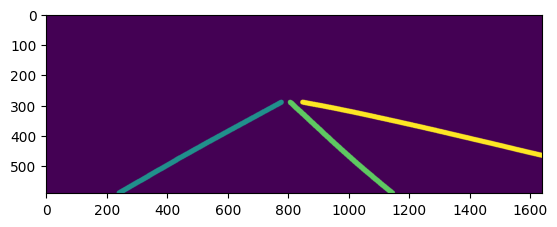

In [54]:
ex_mask = Image.open('/work/dataset/CULane/laneseg_label_w16/driver_23_30frame/05151640_0419.MP4/00000.png')
print("original image size: ", ex_mask.size)
ex_mask_original = np.array(ex_mask)
plt.imshow(ex_mask_original)

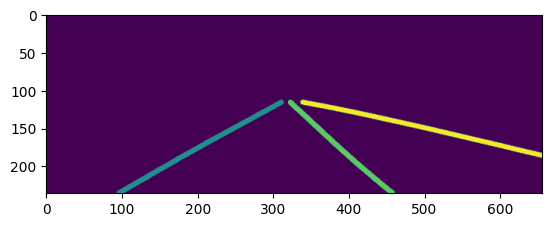

In [55]:
# need to rescale image to save gpu memory: directly using 1640x590 images to fit requires too much cuda memory (8 * 48601MB GPU Memory is not sufficient!)
ex_mask_resize = ex_mask.resize([656, 236])
ex_mask_resize_np = np.array(ex_mask_resize)
plt.imshow(ex_mask_resize_np)

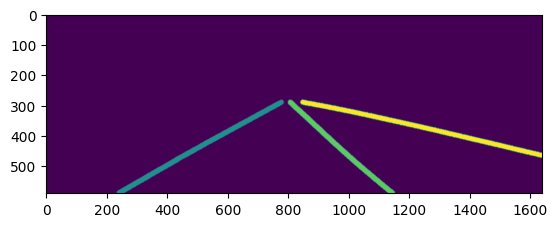

In [56]:
# re-rescale the image to original size. output images almost identical to original image
ex_mask_restore = Image.fromarray(ex_mask_resize_np)
ex_mask_restore = ex_mask_restore.resize([1640, 590])
ex_mask_restore_np = np.array(ex_mask_restore)
plt.imshow(ex_mask_restore_np)

In [57]:
sum(sum((ex_mask_original != ex_mask_restore_np))) # 10639 pixels are not identical...

8043

In [64]:
print("number of background pixels in resized image: ", (ex_mask_resize_np==0).sum())
print("number of 1st lane pixels in resized image: ", (ex_mask_resize_np==1).sum())
print("number of 2nd lane pixels in resized image: ", (ex_mask_resize_np==2).sum())
print("number of 3rd lane pixels in resized image: ", (ex_mask_resize_np==3).sum())
print("number of 4th lane pixels in resized image: ", (ex_mask_resize_np==4).sum())
print("total number of pixels: ", (ex_mask_resize_np==0).sum() + (ex_mask_resize_np==1).sum() + (ex_mask_resize_np==2).sum() + (ex_mask_resize_np==3).sum()
      + (ex_mask_resize_np==4).sum())

number of background pixels in resized image:  149177
number of 1st lane pixels in resized image:  460
number of 2nd lane pixels in resized image:  1952
number of 3rd lane pixels in resized image:  1331
number of 4th lane pixels in resized image:  1896
total number of pixels:  154816


In [65]:
print("number of background pixels in original image: ", (ex_mask_original==0).sum())
print("number of 1st lane pixels in original image: ", (ex_mask_original==1).sum())
print("number of 2nd lane pixels in original image: ", (ex_mask_original==2).sum())
print("number of 3nd lane pixels in original image: ", (ex_mask_original==3).sum())
print("number of 4nd lane pixels in original image: ", (ex_mask_original==4).sum())
print("total number of pixels: ", (ex_mask_original==0).sum() + (ex_mask_original==1).sum() + (ex_mask_original==2).sum() + (ex_mask_original==3).sum()
      + (ex_mask_original==4).sum())

number of background pixels in original image:  935363
number of 1st lane pixels in original image:  0
number of 2nd lane pixels in original image:  10606
number of 3nd lane pixels in original image:  8074
number of 4nd lane pixels in original image:  13557
total number of pixels:  967600


In [76]:
##### try with albumentation Resize method
import albumentations as A

ex_mask = Image.open('/work/dataset/CULane/laneseg_label_w16/driver_23_30frame/05151640_0419.MP4/00000.png')
ex_mask_original = np.array(ex_mask)
ex_img = Image.open('/work/dataset/CULane/driver_23_30frame/05151640_0419.MP4/00000.jpg')
ex_img = np.array(ex_img)


resizing = A.Compose([
    A.Resize(236, 650) # height, width
])

restore = A.Compose([
    A.Resize(590, 1640)
])

transformed = resizing(image=ex_img, mask=ex_mask_original)
ex_img_resized = transformed['image']
ex_mask_resized = transformed['mask']

transformed2 = restore(image=ex_img_resized, mask=ex_mask_resized)
ex_img_restored = transformed2['image']
ex_mask_restored = transformed2['mask']

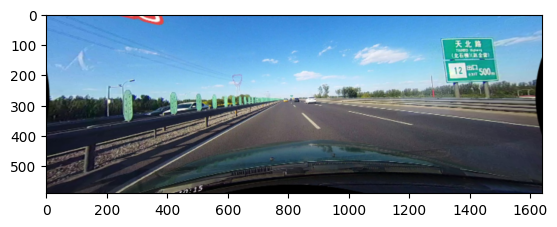

In [ ]:
plt.imshow(ex_img_resized)

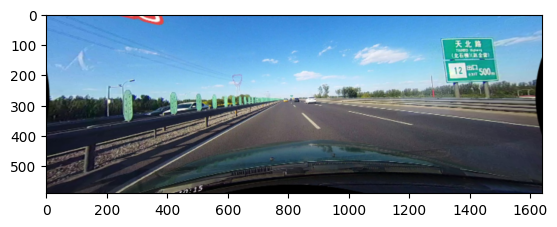

In [80]:
plt.imshow(ex_img_restored)

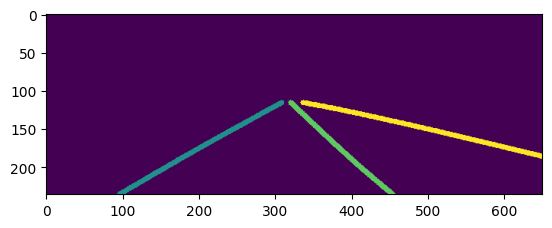

In [81]:
plt.imshow(ex_mask_resized)

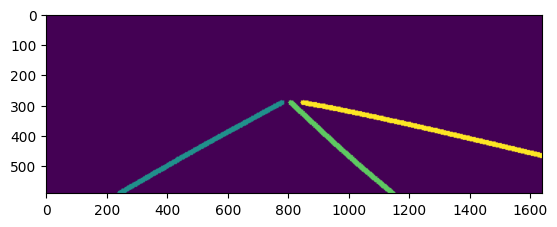

In [82]:
plt.imshow(ex_mask_restored)

In [83]:
# as expected, albumentation Resize() method resize masks very accurately!
print("number of background pixels in resized image: ", (ex_mask_resized==0).sum())
print("number of 1st lane pixels in resized image: ", (ex_mask_resized==1).sum())
print("number of 2nd lane pixels in resized image: ", (ex_mask_resized==2).sum())
print("number of 3rd lane pixels in resized image: ", (ex_mask_resized==3).sum())
print("number of 4th lane pixels in resized image: ", (ex_mask_resized==4).sum())
print("total number of pixels: ", (ex_mask_resized==0).sum() + (ex_mask_resized==1).sum() + (ex_mask_resized==2).sum() + (ex_mask_resized==3).sum()
      + (ex_mask_resized==4).sum())

print() # it is resized, while the ratio of label pixels are maintained!
print("number of background pixels in original image: ", (ex_mask_original==0).sum())
print("number of 1st lane pixels in original image: ", (ex_mask_original==1).sum())
print("number of 2nd lane pixels in original image: ", (ex_mask_original==2).sum())
print("number of 3nd lane pixels in original image: ", (ex_mask_original==3).sum())
print("number of 4nd lane pixels in original image: ", (ex_mask_original==4).sum())
print("total number of pixels: ", (ex_mask_original==0).sum() + (ex_mask_original==1).sum() + (ex_mask_original==2).sum() + (ex_mask_original==3).sum()
      + (ex_mask_original==4).sum())

print() # it is restored to original mask size, while the number of pixels for each classes are almost identical!
print("number of background pixels in original image: ", (ex_mask_restored==0).sum())
print("number of 1st lane pixels in original image: ", (ex_mask_restored==1).sum())
print("number of 2nd lane pixels in original image: ", (ex_mask_restored==2).sum())
print("number of 3nd lane pixels in original image: ", (ex_mask_restored==3).sum())
print("number of 4nd lane pixels in original image: ", (ex_mask_restored==4).sum())
print("total number of pixels: ", (ex_mask_restored==0).sum() + (ex_mask_restored==1).sum() + (ex_mask_restored==2).sum() + (ex_mask_restored==3).sum()
      + (ex_mask_restored==4).sum())

number of background pixels in resized image:  148300
number of 1st lane pixels in resized image:  0
number of 2nd lane pixels in resized image:  1678
number of 3rd lane pixels in resized image:  1271
number of 4th lane pixels in resized image:  2151
total number of pixels:  153400

number of background pixels in original image:  935363
number of 1st lane pixels in original image:  0
number of 2nd lane pixels in original image:  10606
number of 3nd lane pixels in original image:  8074
number of 4nd lane pixels in original image:  13557
total number of pixels:  967600

number of background pixels in original image:  935442
number of 1st lane pixels in original image:  0
number of 2nd lane pixels in original image:  10576
number of 3nd lane pixels in original image:  8016
number of 4nd lane pixels in original image:  13566
total number of pixels:  967600
